In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.data import shepp_logan_phantom
from skimage.transform import resize

import deepinv as dinv
import torch
from deepinv.models import DnCNN, DRUNet, GSDRUNet, GSPnP, RED
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves

n = 64

circle = False
n_angles = 60
theta = np.linspace(0., 180.,n_angles, endpoint=False)
sigma = 100e-1
size = (radon(np.zeros((n,n)), theta=theta, circle = circle)).shape
M = size[0]*size[1]
A = np.zeros((M, n**2))
for i in range(n**2):
    e = np.zeros((n**2,))
    e[i]=1
    e = np.reshape(e,(n,n))
    sinogram = radon(e, theta=theta, circle = circle)
    A[:,i] = np.reshape(sinogram[:], (M,))

# Load the Shepp-Logan phantom
phantom = resize(shepp_logan_phantom(), (n,n))

#ground truth
x = phantom.reshape(-1)

#b
y = np.reshape(A@x, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')

ImportError: cannot import name 'RED' from 'deepinv.models' (c:\Users\as5057\python-test\venv\Lib\site-packages\deepinv\models\__init__.py)

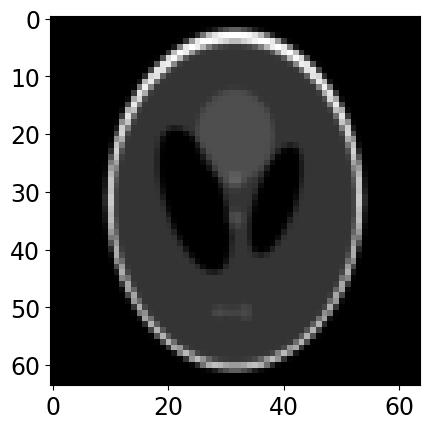

In [84]:
plt.imshow(x.reshape(n,n), cmap = "gray")

In [2]:
device = 'cpu'
url = get_image_url("SheppLogan.png")
img = load_url_image(url=url, img_size= n, grayscale=True, resize_mode="resize", device="cpu")
imsize = (64, 64)

x = torch.tensor(img, device=device, dtype=torch.float)
x = torch.nn.functional.interpolate(x, size= imsize)
img_size = x.shape[1:]





C:\Users\as5057\AppData\Local\Temp\ipykernel_3708\3514784342.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img, device=device, dtype=torch.float)


In [29]:
noise = 0.5
# Forward model (Radon transform with Gaussian noise)
radon = dinv.physics.Tomography(img_width = n,
                                angles = n,
                                device = "cpu",
                                noise_model = dinv.physics.GaussianNoise(sigma = noise),
)
x.shape

torch.Size([1, 1, 64, 64])

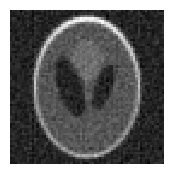

In [4]:
y = radon(x)
fbp = radon.A_dagger(y)
plot(fbp)

# Prior and parameters setup with the models initialised



In [5]:
params = {"stepsize": 0.01, "lambda": 1e-1, "g_param": noise}
max_iter = 200
channels = 1 #3 for RGB, 1 for greyscale
forward = L2()

# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)

# Classical priors
tvprior = dinv.optim.prior.TVPrior(n_it_max = max_iter)
bm3dprior = dinv.models.BM3D()

priorbm3d = PnP(denoiser = bm3dprior)
prior1 = PnP(denoiser = dncnn)
prior2 = PnP(denoiser = drunet)


In [1]:
#GS-DRUNet class with GSPnP and the GS-DRUNet function
import torch
import torch.nn as nn
from deepinv.models.utils import get_weights_url



class StudentGrad(nn.Module):
    def __init__(self, denoiser):
        super().__init__()
        self.model = denoiser

    def forward(self, x, sigma):
        return self.model(x, sigma)


class GSPnP(nn.Module):
    r"""
    Gradient Step module to use a denoiser architecture as a Gradient Step Denoiser.
    See https://arxiv.org/pdf/2110.03220.pdf.
    Code from https://github.com/samuro95/GSPnP.

    :param nn.Module denoiser: Denoiser model.
    :param float alpha: Relaxation parameter
    """

    def __init__(self, denoiser, alpha=1.0, train=False):
        super().__init__()
        self.student_grad = StudentGrad(denoiser)
        self.alpha = alpha
        self.train = train

    def potential(self, x, sigma, *args, **kwargs):
        N = self.student_grad(x, sigma)
        return (
            0.5
            * self.alpha
            * torch.norm((x - N).view(x.shape[0], -1), p=2, dim=-1) ** 2
        )

    def potential_grad(self, x, sigma, *args, **kwargs):
        r"""
        Calculate :math:`\nabla g` the gradient of the regularizer :math:`g` at input :math:`x`.

        :param torch.Tensor x: Input image
        :param float sigma: Denoiser level :math:`\sigma` (std)
        """
        with torch.enable_grad():
            x = x.float()
            x = x.requires_grad_()
            N = self.student_grad(x, sigma)
            JN = torch.autograd.grad(
                N, x, grad_outputs=x - N, create_graph=True, only_inputs=True
            )[0]
        Dg = x - N - JN
        return self.alpha * Dg

    def forward(self, x, sigma):
        r"""
        Denoising with Gradient Step Denoiser

        :param torch.Tensor x: Input image
        :param float sigma: Denoiser level (std)
        """
        Dg = self.potential_grad(x, sigma)
        x_hat = x - Dg
        return x_hat


def GSDRUNet(
    alpha=1.0,
    in_channels=3,
    out_channels=3,
    nb=2,
    nc=[64, 128, 256, 512],
    act_mode="E",
    pretrained=None,
    train=False,
    device=torch.device("cpu"),
):
    """
    Gradient Step Denoiser with DRUNet architecture

    :param float alpha: Relaxation parameter
    :param int in_channels: Number of input channels
    :param int out_channels: Number of output channels
    :param int nb: Number of blocks in the DRUNet
    :param list nc: Number of channels in the DRUNet
    :param str act_mode: activation mode, "R" for ReLU, "L" for LeakyReLU "E" for ELU and "S" for Softplus.
    :param str downsample_mode: Downsampling mode, "avgpool" for average pooling, "maxpool" for max pooling, and
        "strideconv" for convolution with stride 2.
    :param str upsample_mode: Upsampling mode, "convtranspose" for convolution transpose, "pixelsuffle" for pixel
        shuffling, and "upconv" for nearest neighbour upsampling with additional convolution.
    :param bool download: use a pretrained network. If ``pretrained=None``, the weights will be initialized at random
        using Pytorch's default initialization. If ``pretrained='download'``, the weights will be downloaded from an
        online repository (only available for the default architecture).
        Finally, ``pretrained`` can also be set as a path to the user's own pretrained weights.
        See :ref:`pretrained-weights <pretrained-weights>` for more details.
    :param bool train: training or testing mode.
    :param str device: gpu or cpu.

    """
    from deepinv.models.drunet import DRUNet

    denoiser = DRUNet(
        in_channels=in_channels,
        out_channels=out_channels,
        nb=nb,
        nc=nc,
        act_mode=act_mode,
        pretrained=None,
        train=train,
        device=device,
    )
    GSmodel = GSPnP(denoiser, alpha=alpha, train=train)
    if pretrained:
        if pretrained == "download":
            if in_channels == 3 and out_channels == 3:
                url = get_weights_url(
                    model_name="gradientstep", file_name="GSDRUNet_torch.ckpt"
                )
                ckpt = torch.hub.load_state_dict_from_url(
                    url,
                    map_location=lambda storage, loc: storage,
                    file_name="GSDRUNet_torch.ckpt",
                )
            elif in_channels == 1 and out_channels == 1:
                url = get_weights_url(
                    model_name="gradientstep", file_name="GSDRUNet_grayscale_torch.ckpt"
                )
                ckpt = torch.hub.load_state_dict_from_url(
                    url,
                    map_location=lambda storage, loc: storage,
                    file_name="GSDRUNet_grayscale_torch.ckpt",
                )
        else:
            ckpt = torch.load(pretrained, map_location=lambda storage, loc: storage)

        if "state_dict" in ckpt:
            ckpt = ckpt["state_dict"]

        GSmodel.load_state_dict(ckpt, strict=False)
    return GSmodel


gsdrunet = GSDRUNet(
    in_channels= 1,
    out_channels= 1,
    pretrained="download",
    device="cpu",
)

In [6]:
model1 = optim_builder(
    iteration="PGD",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DnCNN
model2 = optim_builder(
    iteration="PGD",
    prior= prior1,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
model3 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

modelbm3d = optim_builder(
    iteration="PGD",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


In [12]:
from deepinv.optim.prior import RED

class GSPnP(RED):
    r"""
    Gradient-Step Denoiser prior.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.explicit_prior = True

    def g(self, x, *args, **kwargs):
        r"""
        Computes the prior :math:`g(x)`.

        :param torch.tensor x: Variable :math:`x` at which the prior is computed.
        :return: (torch.tensor) prior :math:`g(x)`.
        """
        return self.denoiser.potential(x, *args, **kwargs)

#gsprior = GSPnP
gsdrunet = GSDRUNet(
    pretrained="download",
    device="cpu",
)

gsprior = GSPnP(denoiser = gsdrunet)



modelGSPnP = optim_builder(
    iteration="PGD",
    prior= gsprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


In [ ]:
imgs = [y, x, fbp, x1, x2, x3, x4, x5]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "TV 1e-1", "TV 1", "TV 1e+1", "TV 1e+2", "TV 1e+3" ])

In [16]:
x_model1, metrics1 = model1(y, radon, x_gt = x, compute_metrics = True)
x_model2, metrics2 = model2(y, radon, x_gt = x, compute_metrics = True)
x_model3, metrics3 = model3(y, radon, x_gt = x, compute_metrics = True)


Iteration 33, current converge crit. = 5.75E-06, objective = 1.00E-05 


In [17]:
x_modelbm3d, metricsbm3d = modelbm3d(y, radon, x_gt = x, compute_metrics = True)

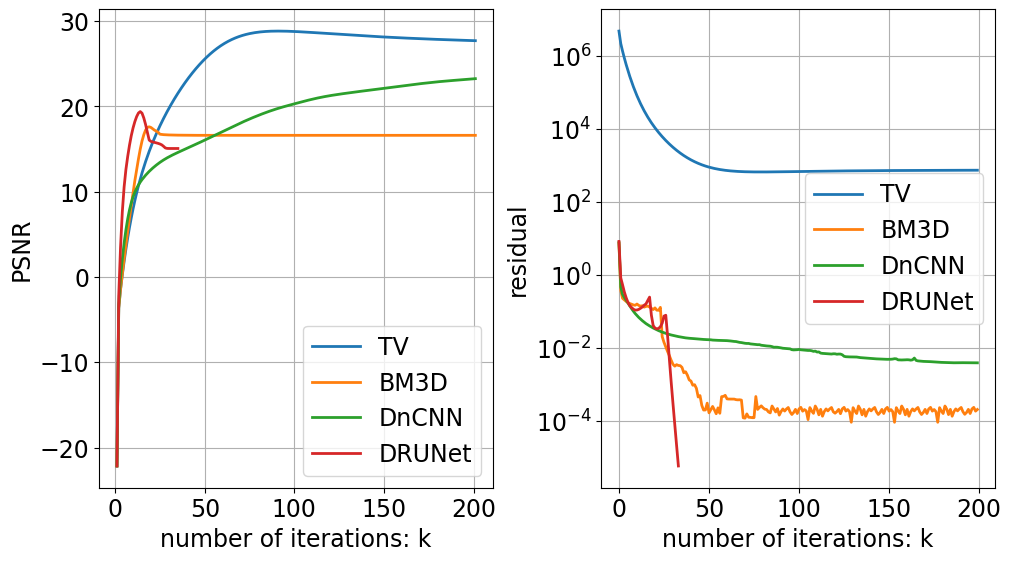

In [18]:
"""
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
"""
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """


    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()
    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(residuals, label = method)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)
    
    return round(psnrs[-1], 2)

tvpsnr = plot_psnrs_residuals(metrics1, 'TV')
bm3dpsnr = plot_psnrs_residuals(metricsbm3d, 'BM3D')
dncnnpsnr = plot_psnrs_residuals(metrics2, 'DnCNN')
drunetpsnr =plot_psnrs_residuals(metrics3, 'DRUNet')

psnrs_list = [tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr]

ax1.legend()
ax2.legend()

In [ ]:
def plt_ready(ground_truth, y, FBP, x_tv, x_bm3d, x_dncnn, x_drunet, imsize):
    sinogram = y.view(91,64)
    gt = ground_truth.view(imsize)
    fbp = FBP.view(imsize)
    tv_x = x_tv.view(imsize)
    bm3d_x = x_bm3d.view(imsize)
    dncnn_x = x_dncnn.view(imsize)
    drunet_x = x_drunet.view(imsize)

    return sinogram, gt, fbp, tv_x, bm3d_x, dncnn_x, drunet_x

def plotting_estimates(gt, fbp, x1, x2, x3, x4, psnrs_list):
    size = 15
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5))
    fig.subplots_adjust(hspace=0.4)
    axs[0, 0].set_title("Ground Truth", fontsize = size)
    axs[0, 0].imshow(gt, cmap='gray')
    axs[0, 1].set_title("FBP", fontsize = size)
    axs[0, 1].imshow(fbp, cmap='gray')
    axs[0, 2].set_title(f'TV \n PSNR: {psnrs_list[0]:.2f} dB', fontsize = size)
    axs[0, 2].imshow(x1, cmap='gray')
    axs[1, 0].set_title(f'BM3D \n PSNR: {psnrs_list[1]:.2f} dB', fontsize = size)
    axs[1, 0].imshow(x2, cmap='gray')
    axs[1, 1].set_title(f'PnP-DnCNN \n PSNR: {psnrs_list[2]:.2f} dB', fontsize = size)
    axs[1, 1].imshow(x3, cmap='gray')
    axs[1, 2].set_title(f'PnP-DRUNet \n PSNR: {psnrs_list[3]:.2f} dB', fontsize = size)
    axs[1, 2].imshow(x4, cmap='gray')

    for i in range(2):
        for j in range(3):
            axs[i, j].axis('off')

imsize = (n, n)

In [111]:
y.shape

torch.Size([1, 4, 91, 64])

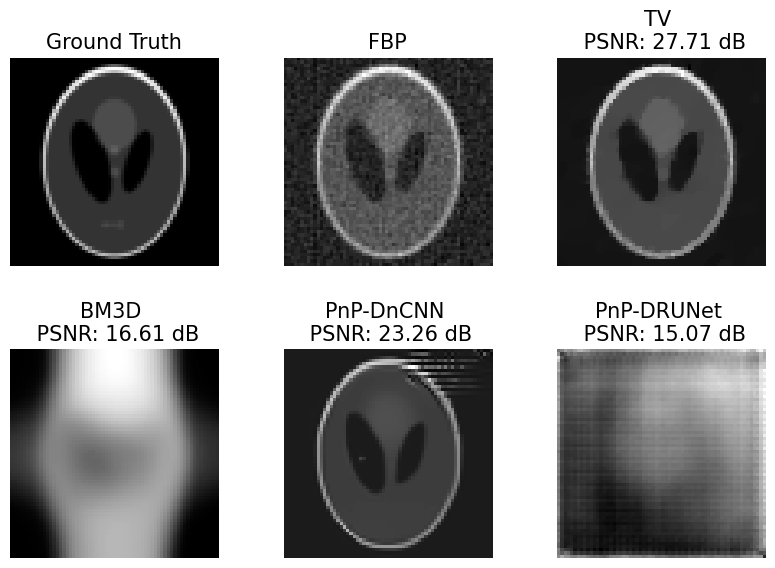

In [20]:
sinogram, ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet = plt_ready(x, y, fbp, x_model1, x_modelbm3d, x_model2, x_model3, imsize)
plotting_estimates(ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet, psnrs_list)

# Deep denoisers adaptation and tuning

In [22]:
p = {"stepsize": 0.01, "g_param": noise}
p1 = {"stepsize": 0.01, "g_param": 5e-4}
p2 = {"stepsize": 0.01, "g_param": 5e-3}
p3 = {"stepsize": 0.01, "g_param": 5e-2}
p4 = {"stepsize": 0.01, "g_param": 5e-1}
p5 = {"stepsize": 0.01, "g_param": 5e+1}
p6 = {"stepsize": 0.01, "g_param": 5e+2}
miter = 300

#DRUNet
t = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = miter,
    verbose = True,
    params_algo=p,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
t1 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = miter,
    verbose = True,
    params_algo=p1,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
t2 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = miter,
    verbose = True,
    params_algo=p2,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)



#DRUNet
t3 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = miter,
    verbose = True,
    params_algo=p3,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)




#DRUNet
t4 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = miter,
    verbose = True,
    params_algo=p4,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
t5 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = miter,
    verbose = True,
    params_algo=p5,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DRUNet
t6 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = miter,
    verbose = True,
    params_algo=p6,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)




In [23]:
r, m = t(y, radon, x_gt = x, compute_metrics = True)
r1, m1 = t1(y, radon, x_gt = x, compute_metrics = True)
r2, m2 = t2(y, radon, x_gt = x, compute_metrics = True)
r3, m3 = t3(y, radon, x_gt = x, compute_metrics = True)
r4, m4 = t4(y, radon, x_gt = x, compute_metrics = True)
r5, m5 = t5(y, radon, x_gt = x, compute_metrics = True)
r6, m6 = t6(y, radon, x_gt = x, compute_metrics = True)

Iteration 33, current converge crit. = 5.75E-06, objective = 1.00E-05 
Iteration 33, current converge crit. = 5.75E-06, objective = 1.00E-05 


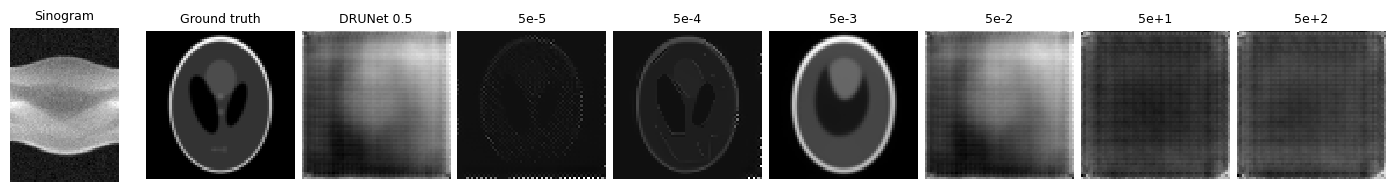

In [25]:
imgs = [y, x, r, r1, r2, r3, r4, r5, r6]
plot(imgs, titles = ["Sinogram", "Ground truth", "DRUNet 0.5", "5e-5", "5e-4", "5e-3", "5e-2", "5e+1", "5e+2" ])

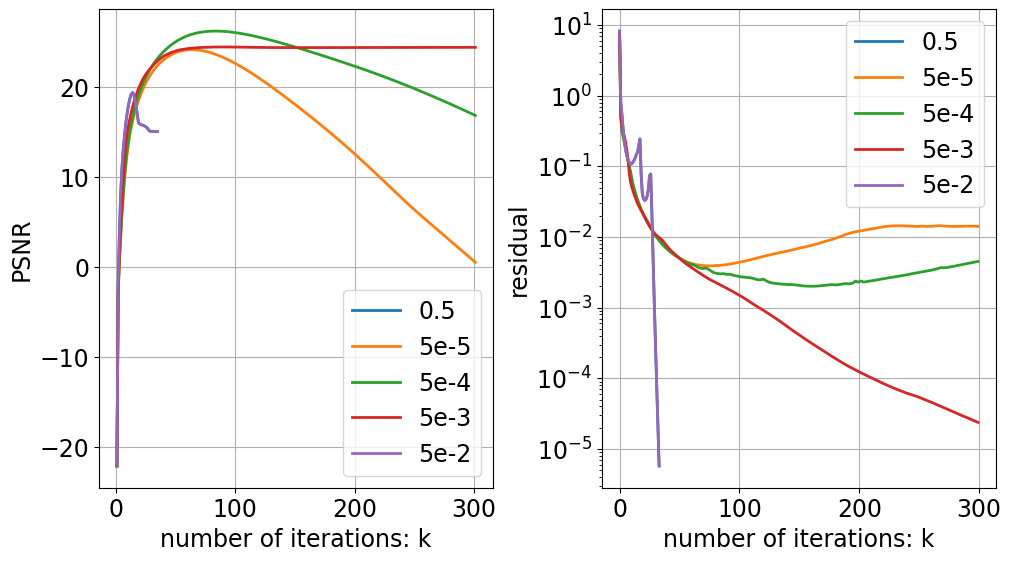

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
def plot_psnrs_residuals1(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """


    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()
    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(residuals, label = method)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)

plot_psnrs_residuals1(m, '0.5')
plot_psnrs_residuals1(m1, '5e-5')
plot_psnrs_residuals1(m2, '5e-4')
plot_psnrs_residuals1(m3, '5e-3')
plot_psnrs_residuals1(m4, '5e-2')
#plot_psnrs_residuals1(m5, '5e+1')
#plot_psnrs_residuals1(m6, '5e+2')

ax1.legend()
ax2.legend()